In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
from os import getcwd
from os.path import join

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
random.seed(42)

In [4]:
work_dir = getcwd()
data_dir = join(work_dir, "data")
image_dir = join(work_dir, "images")

In [5]:
uber_base = {
    "B02512": "Unter",
    "B02598": "Hinter",
    "B02617": "Weiter",
    "B02682": "Schmecken",
    "B02764": "Danach-NY",
    "B02765": "Grun",
    "B02835": "Dreist",
    "B02836": "Drinnen"
}

In [6]:
# liste des fichiers de pickup
uber_pickup_files = {
    "April": "uber-raw-data-apr14.csv",
    "May": "uber-raw-data-may14.csv",
    "June": "uber-raw-data-jun14.csv",
    "July": "uber-raw-data-jul14.csv",
    "August": "uber-raw-data-aug14.csv",
    "September": "uber-raw-data-sep14.csv"
}

In [7]:
files = []
for f in uber_pickup_files.values():
    files.append(pd.read_csv(join(data_dir, f)))
uber = pd.concat(files, ignore_index=True)

In [8]:
uber.shape

(4534327, 4)

In [9]:
uber.tail()

,Date/Time,Lat,Lon,Base
4534322,9/30/2014 22:57:00,40.7668,-73.9845,B02764
4534323,9/30/2014 22:57:00,40.6911,-74.1773,B02764
4534324,9/30/2014 22:58:00,40.8519,-73.9319,B02764
4534325,9/30/2014 22:58:00,40.7081,-74.0066,B02764
4534326,9/30/2014 22:58:00,40.7140,-73.9496,B02764


In [ ]:
quantile_list = [0, .25, .5, .75, 1.]

def quantile_labels(feature_quantiles):
    """
    return the list of the feature quantiles labels
    """
    return [f"{int(feature_quantiles.iloc[q])}-{int(feature_quantiles.iloc[q+1])}" for q in range(len(feature_quantiles) - 1)]

In [10]:
columns = ["Lat", "Lon", "Weekday", "Hour"]

def preprocessing(df):
    
    X = df.copy()
    
    X["Date/Time"] = pd.to_datetime(X["Date/Time"], infer_datetime_format=True)
    X["Month"] = X["Date/Time"].dt.month
    X["Weekday"] = X["Date/Time"].dt.weekday
    X["Hour"] = X["Date/Time"].dt.hour
    X["Location"] = [[a, b] for a, b in zip(X["Lat"].values, X["Lon"].values)]
     
    return X

In [11]:
uber = preprocessing(uber)

In [12]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Date/Time  datetime64[ns]
 1   Lat        float64       
 2   Lon        float64       
 3   Base       object        
 4   Month      int64         
 5   Weekday    int64         
 6   Hour       int64         
 7   Location   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 276.8+ MB


In [14]:
uber.head()

,Date/Time,Lat,Lon,Base,Month,Weekday,Hour,Location
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,4,1,0,"[40.769, -73.9549]"
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,4,1,0,"[40.7267, -74.0345]"
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,4,1,0,"[40.7316, -73.9873]"
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,4,1,0,"[40.7588, -73.9776]"
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,4,1,0,"[40.7594, -73.9722]"


In [15]:
# combien de localisation différente

uber["Lat"].nunique() / uber.shape[0]

0.0015640689345960271

In [16]:
uber["Lon"].nunique() / uber.shape[0]

0.002525843416233545

### Variables non corrélées

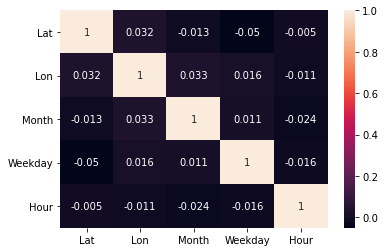

In [17]:
sns.heatmap(uber.corr(), annot=True);

### Bornage des coordonées pour récupérer une carte

In [18]:
uber[["Lat", "Lon"]].min()

Lat    39.6569
Lon   -74.9290
dtype: float64

In [19]:
uber[["Lat", "Lon"]].max()

Lat    42.1166
Lon   -72.0666
dtype: float64

### Echantillonage pour garder de la marge computationnelle

### Calcul de la taille de l'échantillon

Pour une marge d'erreur m de 1% et z correspondant à un niveau de confiance de 99% et en prenant le p le moins favorable

n = z² x p ( 1 – p ) / m²

In [181]:
m = 0.01
z = 2.576
p = 0.5
n = z**2 * p * (1 - p) / m**2
print(f"La taille minimale de l'échantillon est de {n:.0f}")

La taille minimale de l'échantillon est de 16589


In [21]:
# on restreint le nombre d'individus à 100000

X = uber.values
np.random.shuffle(X)
X = X[np.random.randint(0, X.shape[0], 100000)]

In [22]:
X = pd.DataFrame(X, columns=uber.columns)

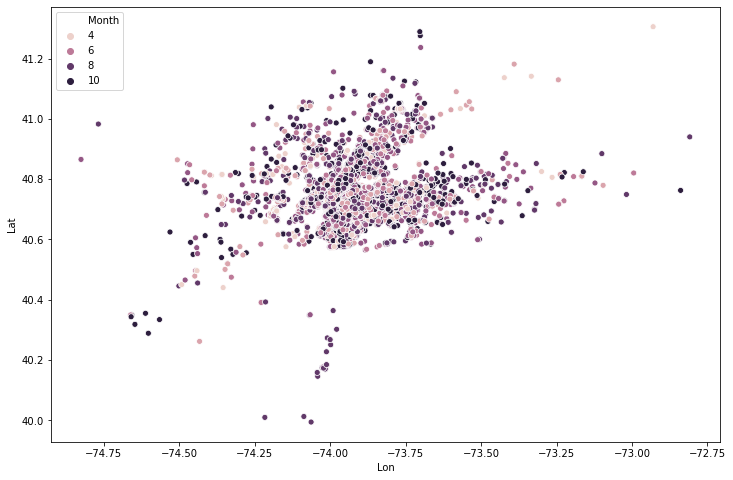

In [76]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=X, x="Lon", y="Lat", hue="Month", ax=ax);
#fig.savefig(join(image_dir, "coordinates_by_month.png"), transparent=False, dpi=80, bbox_inches="tight")

##### On garde les variables continues et on standardise

In [23]:
sc_X = StandardScaler()
X_st = sc_X.fit_transform(X[columns])

### Recherche du nombre de cluster optimal

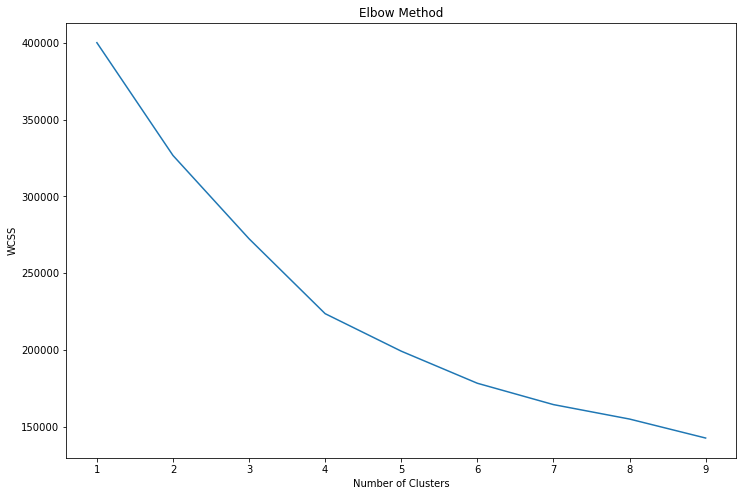

<IPython.core.display.Javascript object>

In [84]:
%%notify -m "Elbow terminé"

# créer une boucle pour stocker les inerties calculées pour chaque kmeans en itérant sur le nombre de cluster

n_clusters = 10

wcss = []
for i in range (1, n_clusters): 
    kmeans = KMeans(n_clusters= i, init = "k-means++", max_iter = 300, n_init = 10)
    kmeans.fit(X_st)
    wcss.append(kmeans.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(range(1, n_clusters), wcss)
ax.set_title('Elbow Method')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('WCSS')

plt.show()
#fig.savefig(join(image_dir, "Elbow.png"), transparent=False, dpi=80, bbox_inches="tight")

### Un coude semble se dessiner à 4 clusters
Essai (!) de confirmation avec la silouhette

For n_clusters = 3, the average silhouette_score is : 0.2574994990197603
For n_clusters = 4, the average silhouette_score is : 0.259246787279798
For n_clusters = 5, the average silhouette_score is : 0.22357876781740818


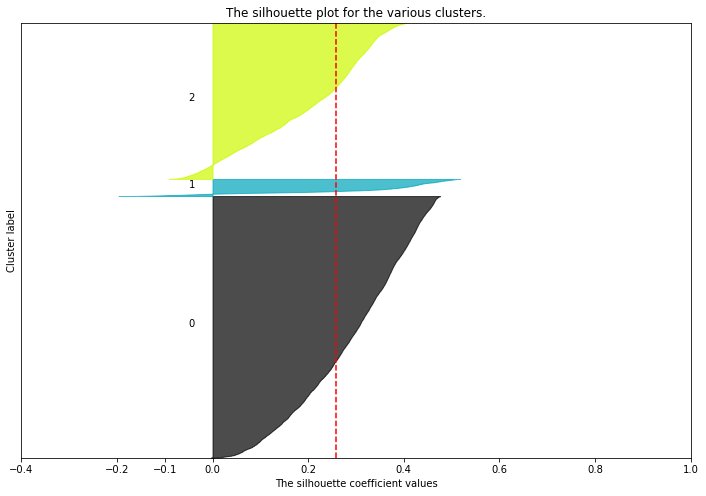

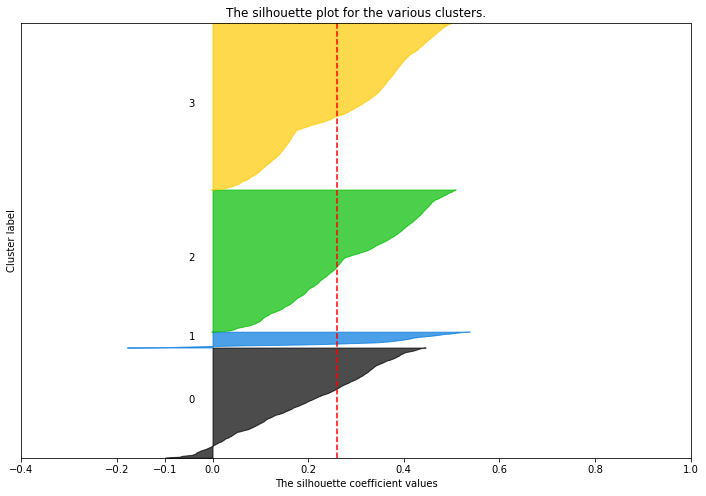

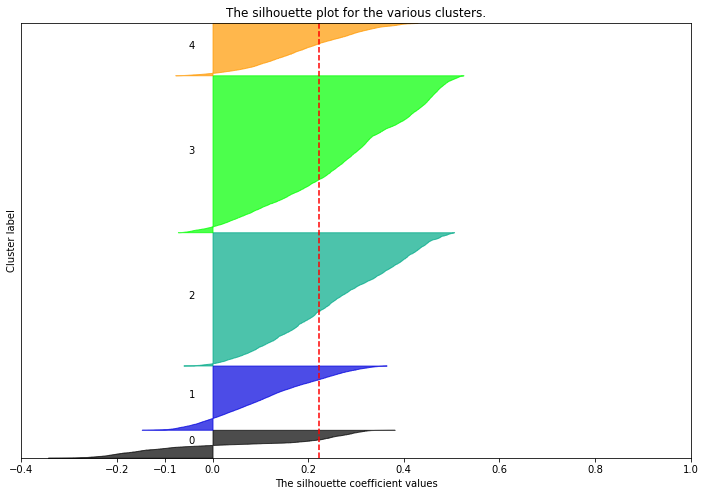

<IPython.core.display.Javascript object>

In [86]:
%%notify -m "Silhouette terminée"

range_n_clusters = [3, 4, 5]

for n_clusters in range_n_clusters:
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # The silhouette coefficient can range from -1, 1
    
    ax.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X_st) + (n_clusters + 1) * 10])
    
    clusterer = MiniBatchKMeans(n_clusters=n_clusters, 
                                init = "k-means++", 
                                max_iter = 300, 
                                n_init = 10, 
                                batch_size=100)
    
    cluster_labels = clusterer.fit_predict(X_st)

    silhouette_avg = silhouette_score(X_st, cluster_labels)
    print(f"For {n_clusters = }, the average silhouette_score is : {silhouette_avg}")
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_st, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()
fig.savefig(join(image_dir, "silhouette.png"), transparent=False, dpi=80, bbox_inches="tight")

### On garde le nombre de 4 clusters

### K-means à 4 clusters

In [182]:
%%notify -m "4-means terminé"

kmeans = KMeans(n_clusters=4, init="k-means++", max_iter=100, n_init=10)
kmeans.fit(X_st)
y_kmeans = kmeans.predict(X_st)

<IPython.core.display.Javascript object>

In [88]:
centroids = kmeans.cluster_centers_
centroids

array([[-1.78191441,  3.48129058,  0.06399658,  0.04856742],
       [ 0.02224289, -0.11634946,  0.12473447, -1.35360123],
       [ 0.15019639, -0.1308083 , -1.02812353,  0.35632745],
       [ 0.02783435, -0.13991497,  0.7474035 ,  0.5630503 ]])

### Coordonnées des centroïdes

In [89]:
centroids = pd.DataFrame(sc_X.inverse_transform(centroids), columns=columns)
centroids

,Lat,Lon,Weekday,Hour
0,40.667269,-73.776285,3.085612,14.511185
1,40.740238,-73.979598,3.199607,6.172363
2,40.745413,-73.980415,1.035871,16.341461
3,40.740464,-73.980929,4.368261,17.570860


In [90]:
X["4_means"] = y_kmeans

In [91]:
X.head()

,Date/Time,Lat,Lon,Base,Month,Weekday,Hour,Location,4_means
0,2014-09-20 18:14:00,40.7516,-73.9753,B02617,9,5,18,"[40.7516, -73.9753]",3
1,2014-08-15 19:45:00,40.736,-73.8605,B02617,8,4,19,"[40.736, -73.8605]",3
2,2014-09-12 17:07:00,40.715,-73.99,B02682,9,4,17,"[40.715, -73.99]",3
3,2014-05-08 19:26:00,40.7793,-73.9615,B02617,5,3,19,"[40.7793, -73.9615]",3
4,2014-07-02 20:08:00,40.7435,-73.9727,B02598,7,2,20,"[40.7435, -73.9727]",2


### Sampling pour les visualisations

stockage des images et "textification" du code pour permettre un affichade sur github des grapg Plotly

In [92]:
X_sample = X.sample(20000)

4-means clusters :
![alt tex](images/4-means_pickup.png)

### discrétisation des heures par quartiles pour une meilleure lisibilité

In [42]:
hour_quantiles = X_sample["Hour"].quantile(quantile_list)
hour_bins_labels = quantile_labels(hour_quantiles)
X_sample["Hour"] = pd.qcut(X_sample["Hour"], q=quantile_list, labels=hour_bins_labels)

In [100]:
X_sample.head()

,Date/Time,Lat,Lon,Base,Month,Weekday,Hour,Location,4_means
13142,2014-07-03 11:46:00,40.7569,-73.961,B02598,7,3,10-16,"[40.7569, -73.961]",1
72719,2014-09-06 20:17:00,40.7425,-73.9781,B02598,9,5,19-23,"[40.7425, -73.9781]",3
13023,2014-07-17 03:16:00,40.7563,-73.9831,B02617,7,3,0-10,"[40.7563, -73.9831]",1
89544,2014-05-17 20:06:00,40.7833,-73.9471,B02598,5,5,19-23,"[40.7833, -73.9471]",3
89432,2014-05-20 17:48:00,40.7616,-73.9845,B02598,5,1,16-19,"[40.7616, -73.9845]",2


4-means clusters by hour
![alt text](images/4-means_pickup_by_hours.png)

## DBSCAN
### Recherche d'un epsilon

In [194]:
def plot_epsilon_elbow(X):
    nearest = NearestNeighbors(n_neighbors=2, n_jobs=-1)
    neighbours = nearest.fit(X)

    dist, ind = neighbours.kneighbors(X)

    dist = np.sort(dist, axis=0)
    dist = dist[:,1]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(dist)
    ax.set_title("DBSCAN epsilon elbow")
    plt.show()

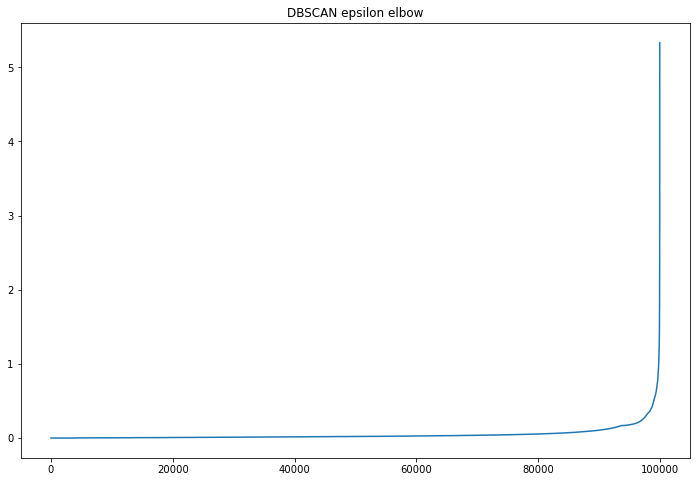

In [195]:
plot_epsilon_elbow(X_st)

##### On teste epsilon = 0.5

In [168]:
%%notify -m "DBSCAN terminé"

dbscan = DBSCAN(eps=0.55, min_samples=60)
y_dbscan = dbscan.fit_predict(X_st)

print(len(np.unique(dbscan.labels_)))

X["dbscan"] = y_dbscan

6

In [169]:
X.head()

,Date/Time,Lat,Lon,Base,Month,Weekday,Hour,Location,dbscan
0,2014-09-08 22:48:00,40.7217,-73.989,B02598,9,0,22,"[40.7217, -73.98899999999999]",0
1,2014-06-14 23:07:00,40.7738,-73.8739,B02598,6,5,23,"[40.7738, -73.8739]",0
2,2014-07-02 20:42:00,40.7341,-74.0031,B02617,7,2,20,"[40.7341, -74.0031]",0
3,2014-08-04 08:37:00,40.8001,-74.2543,B02598,8,0,8,"[40.8001, -74.2543]",-1
4,2014-09-17 19:30:00,40.8024,-73.9506,B02682,9,2,19,"[40.8024, -73.9506]",0


In [171]:
X_sample = X.sample(20000)
print(X_sample["dbscan"].nunique())
hour_quantiles = X_sample["Hour"].quantile(quantile_list)
hour_bins_labels = quantile_labels(hour_quantiles)
X_sample["Hour"] = pd.qcut(X_sample["Hour"], q=quantile_list, labels=hour_bins_labels)

DBSCAN clusters
![alt text](images/dbscan_pickup_clusters.png)

DBSCAN cluster 1
![alt text](images/dbscan_pickup_cluster_1.png)
DBSCAN cluster 2
![alt text](images/dbscan_pickup_cluster_2.png)
DBSCAN cluster 3
![alt text](images/dbscan_pickup_cluster_3.png)
DBSCAN cluster 4
![alt text](images/dbscan_pickup_cluster_4.png)
DBSCAN cluster outliers
![alt text](images/dbscan_pickup_cluster_out.png)

### Restriction au cluster 0

In [198]:
X_0 = X[X["dbscan"] == 0].drop("dbscan", axis=1)

In [199]:
X_0.shape

(92676, 8)

In [200]:
X_0.head()

,Date/Time,Lat,Lon,Base,Month,Weekday,Hour,Location
0,2014-09-08 22:48:00,40.7217,-73.989,B02598,9,0,22,"[40.7217, -73.98899999999999]"
1,2014-06-14 23:07:00,40.7738,-73.8739,B02598,6,5,23,"[40.7738, -73.8739]"
2,2014-07-02 20:42:00,40.7341,-74.0031,B02617,7,2,20,"[40.7341, -74.0031]"
4,2014-09-17 19:30:00,40.8024,-73.9506,B02682,9,2,19,"[40.8024, -73.9506]"
5,2014-07-02 01:31:00,40.6813,-74.0075,B02682,7,2,1,"[40.6813, -74.0075]"


In [201]:
X_0_st = sc_X.transform(X_0[columns])

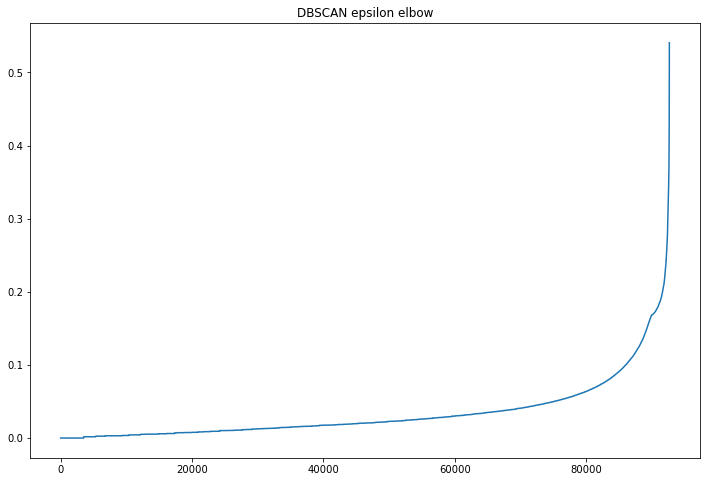

In [202]:
plot_epsilon_elbow(X_0_st)

### epsilon trouvé non concluant dans le clustering

In [291]:
%%notify -m "DBSCAN terminé"

dbscan = DBSCAN(eps=0.55, min_samples=100)
y_dbscan = dbscan.fit_predict(X_0_st)

print(len(np.unique(dbscan.labels_)))

X_0["dbscan"] = y_dbscan

4


<IPython.core.display.Javascript object>

In [292]:
X_sample = X_0.sample(20000)
print(X_sample["dbscan"].nunique())
hour_quantiles = X_sample["Hour"].quantile(quantile_list)
hour_bins_labels = quantile_labels(hour_quantiles)
X_sample["Hour"] = pd.qcut(X_sample["Hour"], q=quantile_list, labels=hour_bins_labels)

4


DBSCAN cluster 0 restreint
![alt text](images/cluster_0_dbscan_pickup.png)